In [1]:
from econ_regime.econ_regime import *
from price.macro_info import get_econ_info
from price.price_processing import *
from strategy.factors.momentum import *
from strategy.factors.volatility import *
from strategy.factors.beta import *
from strategy.optimize.cross_sectional import *
from backtest.metric import *

import pandas as pd
import numpy as np
import statsmodels.api as sm
import bs4 as bs
import requests
import datetime as dt
import pickle5 as pickle

In [2]:
indexes_df = asset_indicators()

equity_df = pd.read_csv('../quant/equity_universe.csv', index_col=0)
equity_df.index = pd.to_datetime(equity_df.index)

equity_universe = equity_df.loc['2011':,].dropna(axis=1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
equity_momentum = MomentumFactor(equity_universe.resample('M').last(), 12, 20).dual_momentum()

In [4]:
ew_weight = Equalizer(signal=equity_momentum, rebal_price=equity_universe.resample('M').last().iloc[12:], param=12).ew()

In [5]:
(ew_weight * equity_universe.resample('M').last().iloc[12:].pct_change().fillna(0)).sum(axis=1)
factor_portval = calculate_portvals(price_df=equity_universe.loc['2012':,], weight_df=ew_weight, signal_df=equity_momentum,long_only=True)
factor_daily_rets = port_rets(factor_portval, cumulative=False)
factor_cum_rets = port_rets(factor_portval, cumulative=True)

factor_daily_rets.to_csv('result/mom_daily_rets.csv')

Total Returns: 840.43%
CAGR: 21.88%
Annualized Volatility: 23.74%
Skewness: -0.57
Kurtosis: 5.81
Max Drawdown: -36.95%
Max Drawdown Duration: 514.00 days
Annualized Sharp Ratio: 0.75
Annualized Sortino Ratio: 1.25
Annualized Calmar Ratio: 0.59
Annualized VaR: -0.04
Annualized VaR Ratio: 0.02
Annualized CVaR: -0.06
Annualized CVaR Ratio: 0.02
Annualized hit Ratio: 0.57
Annualized GtP Ratio: 0.91


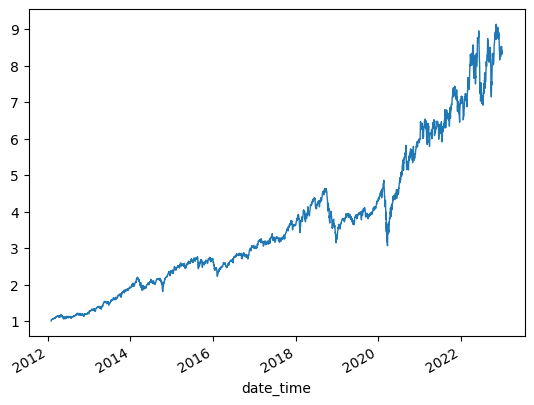

In [6]:
factor_cum_rets.plot(lw=1)
Metric(portfolio=factor_cum_rets, freq='day').print_report()#numeric_metric(dict=False)

AxesSubplot(0.125,0.11;0.775x0.77)


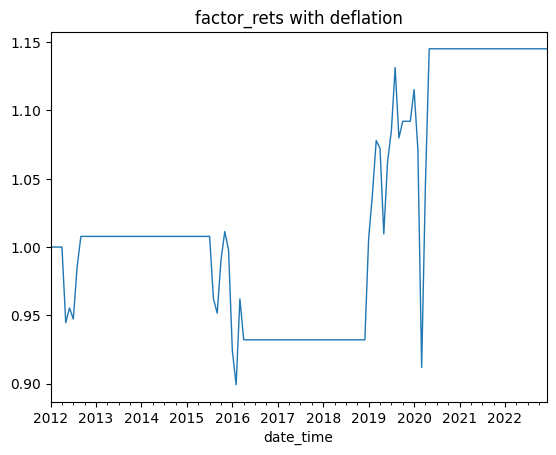

AxesSubplot(0.125,0.11;0.775x0.77)


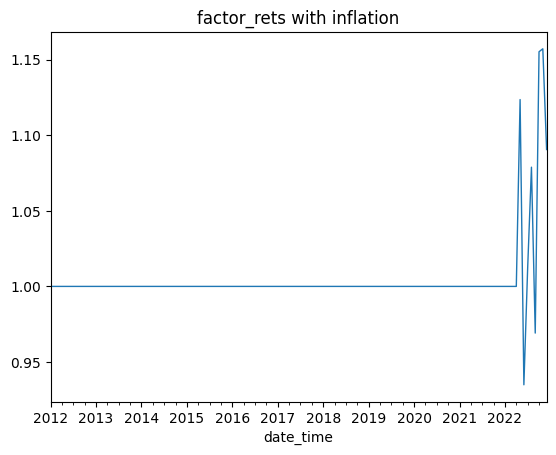

AxesSubplot(0.125,0.11;0.775x0.77)


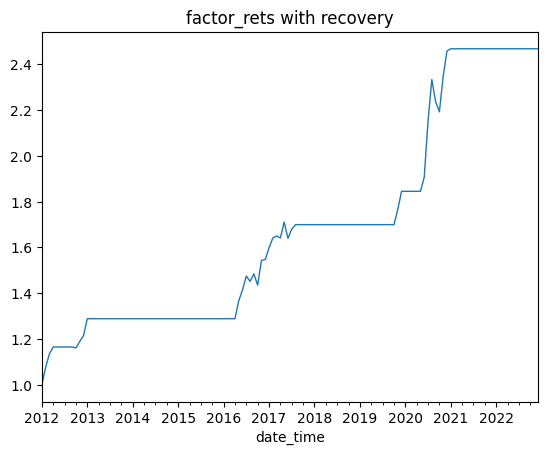

AxesSubplot(0.125,0.11;0.775x0.77)


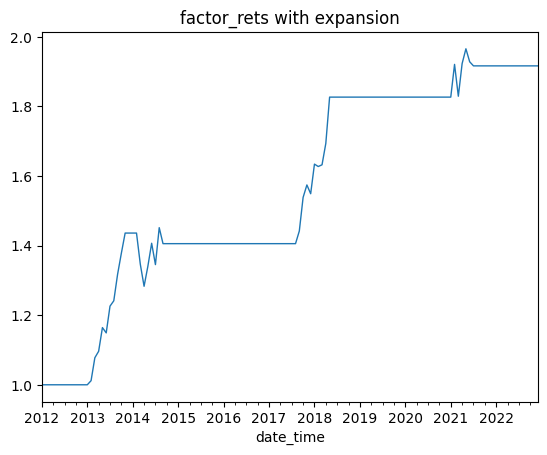

In [7]:
regime_df = business_cycle()
regime_df = regime_df.loc['2012-01':'2022-12']
regime_df.index = factor_daily_rets.resample('M').last().index

fr_df = factor_with_regime(regime_df, factor_cum_rets.resample('M').last().pct_change().fillna(0), 'factor_rets')#.dropna()
check_factor_with_regime(fr_df, 'factor_rets', 'month', plot=True)

### 시황별 성과 확인

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
AxesSubplot(0.125,0.11;0.775x0.77)
AxesSubplot(0.125,0.11;0.775x0.77)
AxesSubplot(0.125,0.11;0.775x0.77)
AxesSubplot(0.125,0.11;0.775x0.77)


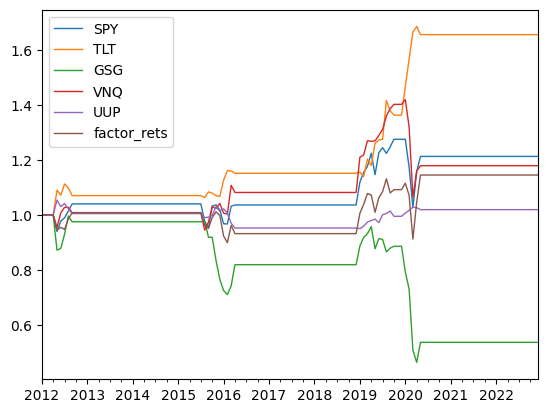

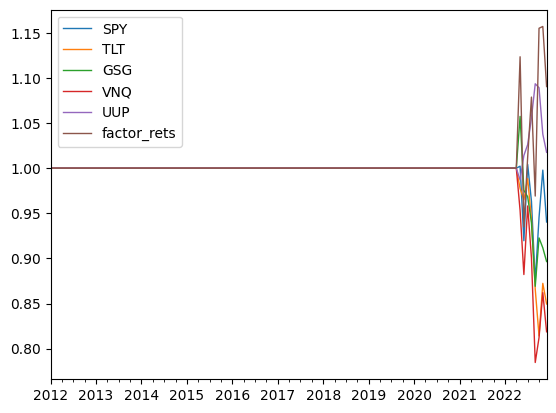

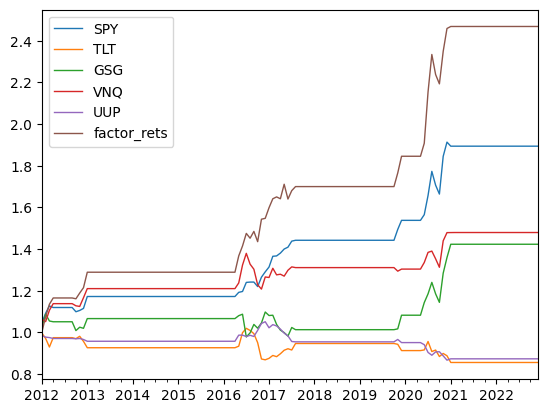

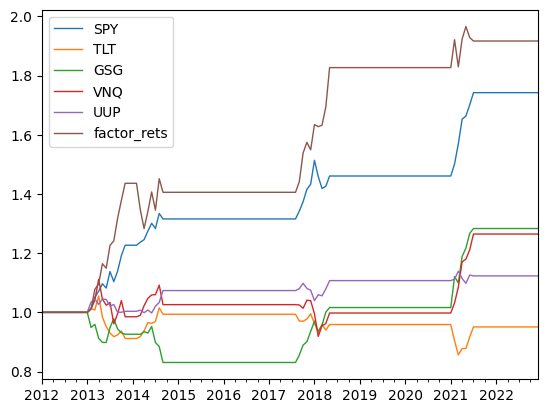

In [8]:
asset_ticker = ['SPY','TLT', 'GSG', 'VNQ', 'UUP']
asset_df = asset_indicators(asset_ticker)

ma_regime_df = multi_asset_df(asset_df, fr_df)
check_best_regime(ma_regime_df, 'month', _plot=True)

### 결과에 따라 투자해보자
- ma_regime_df.loc[(ma_regime_df.recovery == 1),'factor_rets'] = 1
- ma_regime_df.loc[(ma_regime_df.expansion == 1),'factor_rets'] = 1
- ma_regime_df.loc[(ma_regime_df.deflation == 1),'TLT'] = 1
- ma_regime_df.loc[(ma_regime_df.inflation == 1),'UUP'] = 1

In [9]:
alternate_asset_list = ['TLT', 'GSG', 'VNQ', 'UUP']
invest_price = invest_asset_df(indexes_df, factor_cum_rets, alternate_asset_list)

rebal_list = rebal_dates(invest_price, period='month')
rebal_price_df = price_on_rebal(invest_price, rebal_list)

In [10]:
regime_asset_dict = {'recovery': 'factor_rets', 
                    'expansion': 'factor_rets', 
                    'deflation': 'TLT', 
                    'inflation': 'UUP'
                    }

In [11]:
regime_signal_df = regime_signal(ma_regime_df, regime_asset_dict)

regime_signal_df.to_csv('result/mom_regime_signal.csv')

In [12]:
regime_weight = Equalizer(signal=regime_signal_df, rebal_price=rebal_price_df, param=12).ew()
regime_weight = regime_weight.fillna(0)

In [13]:
invest_price
regime_weight
regime_signal_df

,SPY,TLT,GSG,VNQ,UUP,factor_rets,CASH
2012-01-31,0,0,0,0,0,1,0
2012-02-29,0,0,0,0,0,1,0
2012-03-31,0,0,0,0,0,1,0
2012-04-30,0,0,0,0,0,1,0
2012-05-31,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
2022-08-31,0,0,0,0,1,0,0
2022-09-30,0,0,0,0,1,0,0
2022-10-31,0,0,0,0,1,0,0
2022-11-30,0,0,0,0,1,0,0


In [14]:
regime_port = calculate_portvals(price_df=invest_price, weight_df=regime_weight, signal_df=regime_signal_df, long_only=True)
daily = port_rets(regime_port, False)

daily.to_csv('result/mom_regime_daily.csv')

Total Returns: 706.19%
CAGR: 20.24%
Annualized Volatility: 16.83%
Skewness: -0.39
Kurtosis: 5.22
Max Drawdown: -16.94%
Max Drawdown Duration: 286.00 days
Annualized Sharp Ratio: 0.96
Annualized Sortino Ratio: 1.60
Annualized Calmar Ratio: 1.19
Annualized VaR: -0.03
Annualized VaR Ratio: 0.02
Annualized CVaR: -0.04
Annualized CVaR Ratio: 0.02
Annualized hit Ratio: 0.67
Annualized GtP Ratio: 0.63


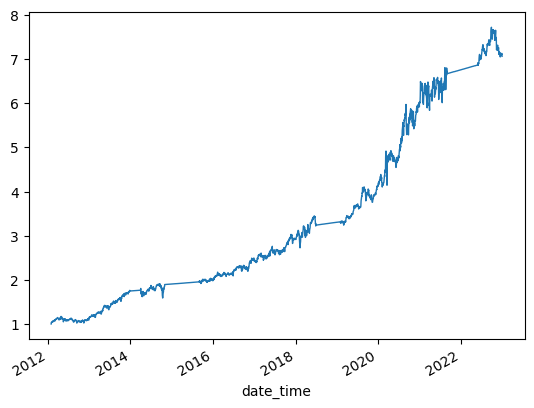

In [15]:
port_rets(regime_port, True).plot(lw=1)
Metric(portfolio=port_rets(regime_port, True)).print_report()